## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Untuk Evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Preprocessing

In [2]:
# Mengatur tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')

# 1. MEMUAT DAN MEMBERSIHKAN DATA
print("1. Memuat dan Membersihkan Data")
file_path = 'IHSG_5_Tahun.csv'
try:
    df_raw = pd.read_csv(file_path, dtype=str)
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Harap periksa path file Anda.")
    exit()

df = df_raw.copy()

def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.replace('.', '')
        value = value.replace(',', '.')
    try:
        return float(value)
    except (ValueError, TypeError):
        if isinstance(value, (int, float)): return value
        return np.nan

def clean_volume_value(value):
    if isinstance(value, str):
        value_upper = value.upper()
        if 'B' in value_upper: value = value_upper.replace('B', 'E9')
        elif 'M' in value_upper: value = value_upper.replace('M', 'E6')
        elif 'K' in value_upper: value = value_upper.replace('K', 'E3')
        value = value.replace('.', '').replace(',', '.')
    try:
        return float(value)
    except (ValueError, TypeError):
        if isinstance(value, (int, float)): return value
        return np.nan

def clean_percentage_value(value):
    if isinstance(value, str):
        value = value.replace('%', '').replace('.', '').replace(',', '.')
    try:
        return float(value) / 100.0
    except (ValueError, TypeError):
        if isinstance(value, (int, float)):
            return value / 100.0 if abs(value) > 1 else value
        return np.nan

cols_to_clean_numeric = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in cols_to_clean_numeric:
    df[col] = df[col].apply(clean_numeric_value)
df['Vol.'] = df['Vol.'].apply(clean_volume_value)
df['Perubahan%'] = df['Perubahan%'].apply(clean_percentage_value)

try:
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
except ValueError as e:
    print(f"Error saat konversi tanggal: {e}. Periksa format kolom 'Tanggal'.")
    exit()

column_mapping = {
    'Tanggal': 'Date', 'Terakhir': 'Close', 'Pembukaan': 'Open',
    'Tertinggi': 'High', 'Terendah': 'Low', 'Vol.': 'Volume',
    'Perubahan%': 'Change_Percent'
}
df.rename(columns=column_mapping, inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df['Volume'].fillna(method='ffill', inplace=True) # Isi dengan nilai sebelumnya
df['Volume'].fillna(0, inplace=True) # Jika masih ada NaN di awal, isi 0
price_cols = ['Close', 'Open', 'High', 'Low'] # Change_Percent juga bisa ditambahkan jika relevan
for col in price_cols:
    df[col].fillna(method='ffill', inplace=True)
df.dropna(subset=price_cols, inplace=True) # Hapus baris jika harga masih NaN

print("\nInformasi dataset (setelah pembersihan):")
df.info()
print("\nMissing values (setelah penanganan NaN):")
print(df.isnull().sum())

1. Memuat dan Membersihkan Data

Informasi dataset (setelah pembersihan):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1205 entries, 2020-05-26 to 2025-05-23
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1205 non-null   float64
 1   Open            1205 non-null   float64
 2   High            1205 non-null   float64
 3   Low             1205 non-null   float64
 4   Volume          1205 non-null   float64
 5   Change_Percent  1205 non-null   float64
dtypes: float64(6)
memory usage: 65.9 KB

Missing values (setelah penanganan NaN):
Close             0
Open              0
High              0
Low               0
Volume            0
Change_Percent    0
dtype: int64


/tmp/ipykernel_7/969844005.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(method='ffill', inplace=True) # Isi dengan nilai sebelumnya
/tmp/ipykernel_7/969844005.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'].fillna(method='ffill', inplace=True) # Isi dengan nilai sebelumnya
/tmp/ipykernel_7/969844005.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through cha

### Hasil dan Insight dari Tahap Pemuatan dan Pembersihan Data

Blok kode di atas telah berhasil menjalankan serangkaian langkah penting untuk memuat dan membersihkan dataset mentah IHSG. Berdasarkan output yang dihasilkan:

1.  **Transformasi Data Berhasil:** Dataset awal yang berisi kolom-kolom dengan tipe data `object` (karena format angka dan tanggal yang spesifik dari sumber) telah berhasil diubah. Fungsi pembersihan kustom (`clean_numeric_value`, `clean_volume_value`, `clean_percentage_value`) efektif dalam menangani format angka Indonesia (pemisah ribuan '.', desimal ',', akhiran 'B'/'M'/'K' pada volume, dan '%' pada persentase). Semua kolom fitur yang relevan ('Close', 'Open', 'High', 'Low', 'Volume', 'Change_Percent') kini memiliki tipe data numerik (`float64`).

2.  **Penanganan Tanggal dan Indeks:** Kolom 'Tanggal' berhasil dikonversi menjadi `DatetimeIndex` dan ditetapkan sebagai indeks DataFrame. Data juga telah diurutkan secara kronologis berdasarkan tanggal ini, yang merupakan prasyarat fundamental untuk analisis deret waktu yang akurat.

3.  **Integritas Data Terjaga:**
    * **Jumlah Data:** Kita sekarang memiliki **1205 entri data historis harian**.
    * **Rentang Waktu:** Data yang bersih ini mencakup periode dari **26 Mei 2020 hingga 23 Mei 2025**, memberikan cakupan data sekitar 5 tahun untuk analisis.
    * **Tidak Ada Missing Values:** Output dari `df.isnull().sum()` menunjukkan bahwa semua kolom sekarang memiliki 0 *missing values*. Langkah-langkah penanganan NaN (menggunakan `ffill` untuk kontinuitas dan `fillna(0)` untuk sisa 'Volume') telah berhasil memastikan tidak ada data yang hilang yang dapat mengganggu proses pemodelan.

4.  **Kesiapan untuk Analisis Lebih Lanjut:** Dengan data yang sudah bersih, memiliki tipe data yang benar, terindeks oleh tanggal, dan bebas dari *missing values*, DataFrame `df` kini siap untuk tahap berikutnya, yaitu Analisis Data Eksploratif (EDA). Pada tahap EDA, kita akan mencoba menggali pola dan wawasan visual dari data ini.

Secara keseluruhan, tahap pra-pemrosesan data ini telah berhasil mengubah data mentah menjadi dataset yang terstruktur dan berkualitas tinggi, yang menjadi fondasi penting untuk membangun model prediksi yang andal.

## EDA


2. Analisis Data Eksploratif (EDA)


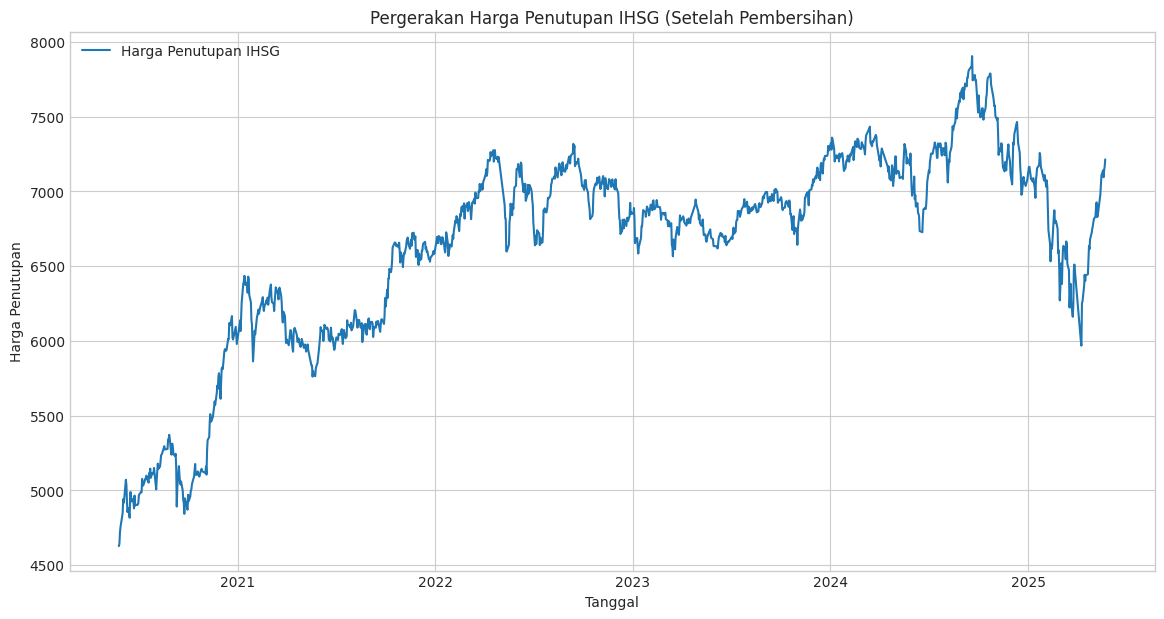

In [3]:
# 2. ANALISIS DATA EKSPLORATIF (EDA)
print("\n2. Analisis Data Eksploratif (EDA)")
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Harga Penutupan IHSG')
plt.title('Pergerakan Harga Penutupan IHSG (Setelah Pembersihan)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

### Analisis Visual: Pergerakan Harga Penutupan IHSG

Plot di atas menampilkan visualisasi pergerakan harga penutupan (`Close`) IHSG selama periode 5 tahun (Mei 2020 - Mei 2025) setelah data dibersihkan. Tujuan dari plot ini adalah untuk mendapatkan pemahaman intuitif mengenai karakteristik utama dari data deret waktu harga IHSG.

**Insight yang Dapat Diperoleh dari Plot:**

* **Tren Umum:** Kita dapat mengamati arah tren jangka panjang IHSG. Apakah cenderung naik (*uptrend*), turun (*downtrend*), atau bergerak menyamping (*sideways* / konsolidasi) selama periode tersebut?
* **Volatilitas:** Plot ini juga memperlihatkan periode-periode di mana harga bergerak dengan fluktuasi yang tinggi (volatilitas tinggi) dibandingkan dengan periode di mana harga relatif stabil.
* **Pola dan Siklus (Jika Ada):** Meskipun siklus atau musiman yang jelas jarang ditemukan pada data harga saham harian, kita bisa mencari pola-pola tertentu atau pergerakan siklikal yang mungkin muncul dalam skala waktu yang lebih besar.
* **Potensi Titik Balik atau Peristiwa Signifikan:** Puncak-puncak (peaks) dan lembah-lembah (troughs) yang tajam pada plot bisa mengindikasikan potensi titik balik tren atau merefleksikan dampak dari peristiwa ekonomi atau pasar tertentu (meskipun untuk identifikasi pasti memerlukan analisis lebih lanjut).

Pemahaman visual ini sangat berguna sebagai dasar sebelum kita melangkah ke tahap persiapan data yang lebih spesifik untuk masing-masing model (Random Forest dan LSTM). Karakteristik seperti tren dan volatilitas dapat memengaruhi bagaimana model akan belajar dan performanya nanti.

## Modeling

### Train Split Data

In [4]:
# 3. PEMBAGIAN DATA GLOBAL (TRAIN-TEST SPLIT AWAL)
print("\n3. Pembagian Data Global")
target_col = 'Close'
if len(df) < 20: # Perlu cukup data untuk lags dan split
    print("Error: Data terlalu sedikit untuk diproses.")
    exit()

train_ratio = 0.8
train_size_global = int(len(df) * train_ratio)
train_df_global = df[:train_size_global].copy()
test_df_global = df[train_size_global:].copy()

print(f"Ukuran data training global: {len(train_df_global)}")
print(f"Ukuran data testing global: {len(test_df_global)}")


3. Pembagian Data Global
Ukuran data training global: 964
Ukuran data testing global: 241


### Random Forest w/ Lagged Features

In [5]:
# 4. MODEL RANDOM FOREST DENGAN LAGGED FEATURES
print("\n4. Model Random Forest dengan Lagged Features")

# --- 4.1 Persiapan Data untuk Random Forest ---
print("   4.1 Persiapan Data untuk Random Forest")
df_rf = df.copy() # Gunakan salinan dari df yang sudah bersih

# Buat lagged features
n_lags = 10 # Jumlah hari sebelumnya yang akan dijadikan fitur
for i in range(1, n_lags + 1):
    df_rf[f'Close_lag_{i}'] = df_rf['Close'].shift(i)
    df_rf[f'Volume_lag_{i}'] = df_rf['Volume'].shift(i)

# Hapus baris dengan NaN yang muncul akibat shifting (lags)
df_rf.dropna(inplace=True)

# Pisahkan fitur (X) dan target (y) untuk Random Forest
features_rf = [col for col in df_rf.columns if 'lag' in col or 'SMA' in col] # Ambil semua fitur lag atau SMA
if not features_rf:
    print("   Error: Tidak ada fitur lagged yang dibuat untuk Random Forest.")
    X_rf, y_rf = pd.DataFrame(), pd.Series() # Kosongkan jika error
else:
    X_rf = df_rf[features_rf]
    y_rf = df_rf['Close']

# Bagi data RF menjadi training dan testing berdasarkan index dari pembagian global
# Ini untuk memastikan kita menguji pada periode yang sama (sebisa mungkin)
if not X_rf.empty:
    X_train_rf = X_rf.loc[X_rf.index.isin(train_df_global.index)]
    y_train_rf = y_rf.loc[y_rf.index.isin(train_df_global.index)]
    X_test_rf = X_rf.loc[X_rf.index.isin(test_df_global.index)]
    y_test_rf_actual = y_rf.loc[y_rf.index.isin(test_df_global.index)] # Target aktual untuk RF
else:
    X_train_rf, y_train_rf, X_test_rf, y_test_rf_actual = [pd.DataFrame()]*4 # Kosongkan

print(f"   Ukuran X_train_rf: {X_train_rf.shape}, y_train_rf: {y_train_rf.shape}")
print(f"   Ukuran X_test_rf: {X_test_rf.shape}, y_test_rf_actual: {y_test_rf_actual.shape}")

predictions_rf = None
if not X_train_rf.empty and not X_test_rf.empty:
    # --- 4.2 Pemodelan Random Forest ---
    print("\n   4.2 Pemodelan Random Forest")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=5)
    print("   Melatih model Random Forest...")
    rf_model.fit(X_train_rf, y_train_rf)

    # Prediksi
    predictions_rf = rf_model.predict(X_test_rf)
else:
    print("   Tidak cukup data untuk melatih atau menguji Random Forest.")


4. Model Random Forest dengan Lagged Features
   4.1 Persiapan Data untuk Random Forest


   Ukuran X_train_rf: (954, 20), y_train_rf: (954,)
   Ukuran X_test_rf: (241, 20), y_test_rf_actual: (241,)

   4.2 Pemodelan Random Forest
   Melatih model Random Forest...


### Tahap 4: Pengembangan Model Random Forest

Pada tahap ini, kita membangun model **Random Forest Regressor** untuk memprediksi harga penutupan IHSG. Prosesnya melibatkan dua langkah utama:

**4.1 Persiapan Data untuk Random Forest:**
* **Pembuatan Fitur Lagged:** Karena Random Forest tidak secara inheren memahami urutan waktu, kita membuat fitur baru berdasarkan data historis. Fitur-fitur ini adalah nilai-nilai 'Close' (harga penutupan) dan 'Volume' dari **10 hari sebelumnya (`n_lags = 10`)**. Ini memberikan konteks masa lalu kepada model.
* **Penanganan NaN:** Baris data awal yang memiliki nilai NaN (karena tidak ada cukup data historis untuk membuat fitur *lagged* pertama) dihapus.
* **Pemisahan Fitur & Target:** Dataset kemudian dibagi menjadi `X_rf` (fitur *lagged*) dan `y_rf` (harga 'Close' yang akan diprediksi).
* **Pembagian Train/Test:** Data `X_rf` dan `y_rf` dibagi lagi menjadi set training (`X_train_rf`, `y_train_rf`) dan set testing (`X_test_rf`, `y_test_rf_actual`) mengikuti pembagian indeks global yang telah ditentukan sebelumnya. Output menunjukkan ukuran data training RF adalah (954 sampel, 20 fitur) dan data testing (241 sampel, 20 fitur).

**4.2 Pemodelan Random Forest:**
* **Inisialisasi Model:** Sebuah model `RandomForestRegressor` diinisialisasi dengan parameter awal (misalnya, `n_estimators=100` pohon, `max_depth=10`).
* **Pelatihan Model:** Model dilatih menggunakan data `X_train_rf` (fitur *lagged*) dan `y_train_rf` (target harga 'Close').
* **Prediksi:** Setelah dilatih, model digunakan untuk menghasilkan prediksi (`predictions_rf`) pada data tes (`X_test_rf`).

Tujuan dari langkah-langkah ini adalah untuk membangun model Random Forest yang dapat belajar dari pola data historis (yang direpresentasikan oleh *lagged features*) untuk membuat prediksi harga di masa depan. Hasil prediksi ini kemudian akan dievaluasi.

### LSTM


5. Model LSTM
   5.1 Persiapan Data untuk LSTM
   Bentuk X_train_lstm: (904, 60, 2), y_train_lstm: (904,)
   Bentuk X_test_lstm: (181, 60, 2), y_test_lstm: (181,)
   Bentuk y_test_actual_lstm_target (untuk evaluasi LSTM): (181,)

   5.2 Pemodelan LSTM


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 60, 50)            10600     


 dropout (Dropout)           (None, 60, 50)            0         


 lstm_1 (LSTM)               (None, 50)                20200     


 dropout_1 (Dropout)         (None, 50)                0         


 dense (Dense)               (None, 25)                1275      


 dense_1 (Dense)             (None, 1)                 26        


Total params: 32101 (125.39 KB)


Trainable params: 32101 (125.39 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


   Melatih model LSTM...
Epoch 1/30


 1/29 [>.............................] - ETA: 1:00 - loss: 0.0383

 3/29 [==>...........................] - ETA: 0s - loss: 0.0673  

 5/29 [====>.........................] - ETA: 0s - loss: 0.0564

 8/29 [=======>......................] - ETA: 0s - loss: 0.0446

11/29 [==========>...................] - ETA: 0s - loss: 0.0356

14/29 [=============>................] - ETA: 0s - loss: 0.0338

17/29 [================>.............] - ETA: 0s - loss: 0.0303

20/29 [===================>..........] - ETA: 0s - loss: 0.0276

23/29 [======================>.......] - ETA: 0s - loss: 0.0250

26/29 [=========================>....] - ETA: 0s - loss: 0.0237

29/29 [==============================] - ETA: 0s - loss: 0.0226

29/29 [==============================] - 3s 44ms/step - loss: 0.0226 - val_loss: 0.0171


Epoch 2/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0553

 4/29 [===>..........................] - ETA: 0s - loss: 0.0426

 7/29 [======>.......................] - ETA: 0s - loss: 0.0282

10/29 [=========>....................] - ETA: 0s - loss: 0.0268

13/29 [============>.................] - ETA: 0s - loss: 0.0314

16/29 [===============>..............] - ETA: 0s - loss: 0.0286

19/29 [==================>...........] - ETA: 0s - loss: 0.0281

22/29 [=====================>........] - ETA: 0s - loss: 0.0259

25/29 [========================>.....] - ETA: 0s - loss: 0.0239

28/29 [===========================>..] - ETA: 0s - loss: 0.0235

29/29 [==============================] - 1s 25ms/step - loss: 0.0233 - val_loss: 0.0068


Epoch 3/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0206

 4/29 [===>..........................] - ETA: 0s - loss: 0.0151

 7/29 [======>.......................] - ETA: 0s - loss: 0.0140

10/29 [=========>....................] - ETA: 0s - loss: 0.0116

13/29 [============>.................] - ETA: 0s - loss: 0.0133

16/29 [===============>..............] - ETA: 0s - loss: 0.0130

19/29 [==================>...........] - ETA: 0s - loss: 0.0122

22/29 [=====================>........] - ETA: 0s - loss: 0.0117

25/29 [========================>.....] - ETA: 0s - loss: 0.0111

28/29 [===========================>..] - ETA: 0s - loss: 0.0109

29/29 [==============================] - 1s 26ms/step - loss: 0.0110 - val_loss: 0.0050


Epoch 4/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0093

 4/29 [===>..........................] - ETA: 0s - loss: 0.0072

 7/29 [======>.......................] - ETA: 0s - loss: 0.0072

10/29 [=========>....................] - ETA: 0s - loss: 0.0066

13/29 [============>.................] - ETA: 0s - loss: 0.0069

16/29 [===============>..............] - ETA: 0s - loss: 0.0076

19/29 [==================>...........] - ETA: 0s - loss: 0.0072

22/29 [=====================>........] - ETA: 0s - loss: 0.0072

25/29 [========================>.....] - ETA: 0s - loss: 0.0069

28/29 [===========================>..] - ETA: 0s - loss: 0.0070

29/29 [==============================] - 1s 26ms/step - loss: 0.0070 - val_loss: 0.0067


Epoch 5/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0066

 4/29 [===>..........................] - ETA: 0s - loss: 0.0055

 7/29 [======>.......................] - ETA: 0s - loss: 0.0057

10/29 [=========>....................] - ETA: 0s - loss: 0.0055

12/29 [===========>..................] - ETA: 0s - loss: 0.0054

15/29 [==============>...............] - ETA: 0s - loss: 0.0061

18/29 [=================>............] - ETA: 0s - loss: 0.0063

21/29 [====================>.........] - ETA: 0s - loss: 0.0061

24/29 [=======================>......] - ETA: 0s - loss: 0.0060

27/29 [==========================>...] - ETA: 0s - loss: 0.0061

29/29 [==============================] - 1s 26ms/step - loss: 0.0063 - val_loss: 0.0046


Epoch 6/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0046

 4/29 [===>..........................] - ETA: 0s - loss: 0.0044

 7/29 [======>.......................] - ETA: 0s - loss: 0.0035

 9/29 [========>.....................] - ETA: 0s - loss: 0.0036

12/29 [===========>..................] - ETA: 0s - loss: 0.0038

15/29 [==============>...............] - ETA: 0s - loss: 0.0047

18/29 [=================>............] - ETA: 0s - loss: 0.0050

21/29 [====================>.........] - ETA: 0s - loss: 0.0050

23/29 [======================>.......] - ETA: 0s - loss: 0.0051

26/29 [=========================>....] - ETA: 0s - loss: 0.0053

28/29 [===========================>..] - ETA: 0s - loss: 0.0054

29/29 [==============================] - 1s 26ms/step - loss: 0.0054 - val_loss: 0.0055


Epoch 7/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0108

 4/29 [===>..........................] - ETA: 0s - loss: 0.0044

 7/29 [======>.......................] - ETA: 0s - loss: 0.0035

 9/29 [========>.....................] - ETA: 0s - loss: 0.0038

12/29 [===========>..................] - ETA: 0s - loss: 0.0048

15/29 [==============>...............] - ETA: 0s - loss: 0.0057

18/29 [=================>............] - ETA: 0s - loss: 0.0060

21/29 [====================>.........] - ETA: 0s - loss: 0.0059

24/29 [=======================>......] - ETA: 0s - loss: 0.0058

27/29 [==========================>...] - ETA: 0s - loss: 0.0059

29/29 [==============================] - 1s 26ms/step - loss: 0.0058 - val_loss: 0.0083


Epoch 8/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0176

 4/29 [===>..........................] - ETA: 0s - loss: 0.0100

 7/29 [======>.......................] - ETA: 0s - loss: 0.0078

10/29 [=========>....................] - ETA: 0s - loss: 0.0077

13/29 [============>.................] - ETA: 0s - loss: 0.0094

16/29 [===============>..............] - ETA: 0s - loss: 0.0093

19/29 [==================>...........] - ETA: 0s - loss: 0.0093

22/29 [=====================>........] - ETA: 0s - loss: 0.0086

24/29 [=======================>......] - ETA: 0s - loss: 0.0086

27/29 [==========================>...] - ETA: 0s - loss: 0.0086

29/29 [==============================] - 1s 26ms/step - loss: 0.0086 - val_loss: 0.0087


Epoch 9/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0112

 4/29 [===>..........................] - ETA: 0s - loss: 0.0078

 7/29 [======>.......................] - ETA: 0s - loss: 0.0071

10/29 [=========>....................] - ETA: 0s - loss: 0.0065

13/29 [============>.................] - ETA: 0s - loss: 0.0081

16/29 [===============>..............] - ETA: 0s - loss: 0.0080

19/29 [==================>...........] - ETA: 0s - loss: 0.0083

22/29 [=====================>........] - ETA: 0s - loss: 0.0078

25/29 [========================>.....] - ETA: 0s - loss: 0.0077

28/29 [===========================>..] - ETA: 0s - loss: 0.0076

29/29 [==============================] - 1s 26ms/step - loss: 0.0076 - val_loss: 0.0055


Epoch 10/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0058

 4/29 [===>..........................] - ETA: 0s - loss: 0.0046

 7/29 [======>.......................] - ETA: 0s - loss: 0.0045

10/29 [=========>....................] - ETA: 0s - loss: 0.0042

13/29 [============>.................] - ETA: 0s - loss: 0.0048

16/29 [===============>..............] - ETA: 0s - loss: 0.0050

19/29 [==================>...........] - ETA: 0s - loss: 0.0054

22/29 [=====================>........] - ETA: 0s - loss: 0.0053

25/29 [========================>.....] - ETA: 0s - loss: 0.0053

28/29 [===========================>..] - ETA: 0s - loss: 0.0053

29/29 [==============================] - 1s 26ms/step - loss: 0.0053 - val_loss: 0.0049


Epoch 11/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0044

 4/29 [===>..........................] - ETA: 0s - loss: 0.0032

 6/29 [=====>........................] - ETA: 0s - loss: 0.0040

 9/29 [========>.....................] - ETA: 0s - loss: 0.0035

12/29 [===========>..................] - ETA: 0s - loss: 0.0039

15/29 [==============>...............] - ETA: 0s - loss: 0.0044

18/29 [=================>............] - ETA: 0s - loss: 0.0051

21/29 [====================>.........] - ETA: 0s - loss: 0.0049

24/29 [=======================>......] - ETA: 0s - loss: 0.0048

27/29 [==========================>...] - ETA: 0s - loss: 0.0048

29/29 [==============================] - 1s 25ms/step - loss: 0.0048 - val_loss: 0.0051


Epoch 12/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0031

 4/29 [===>..........................] - ETA: 0s - loss: 0.0038

 7/29 [======>.......................] - ETA: 0s - loss: 0.0038

10/29 [=========>....................] - ETA: 0s - loss: 0.0038

13/29 [============>.................] - ETA: 0s - loss: 0.0042

16/29 [===============>..............] - ETA: 0s - loss: 0.0044

19/29 [==================>...........] - ETA: 0s - loss: 0.0046

22/29 [=====================>........] - ETA: 0s - loss: 0.0045

25/29 [========================>.....] - ETA: 0s - loss: 0.0045

28/29 [===========================>..] - ETA: 0s - loss: 0.0048

29/29 [==============================] - 1s 25ms/step - loss: 0.0047 - val_loss: 0.0051


Epoch 13/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0034

 4/29 [===>..........................] - ETA: 0s - loss: 0.0037

 7/29 [======>.......................] - ETA: 0s - loss: 0.0035

10/29 [=========>....................] - ETA: 0s - loss: 0.0034

13/29 [============>.................] - ETA: 0s - loss: 0.0036

16/29 [===============>..............] - ETA: 0s - loss: 0.0042

19/29 [==================>...........] - ETA: 0s - loss: 0.0043

22/29 [=====================>........] - ETA: 0s - loss: 0.0041

25/29 [========================>.....] - ETA: 0s - loss: 0.0041

28/29 [===========================>..] - ETA: 0s - loss: 0.0043

29/29 [==============================] - 1s 25ms/step - loss: 0.0043 - val_loss: 0.0046


Epoch 14/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0033

 4/29 [===>..........................] - ETA: 0s - loss: 0.0028

 7/29 [======>.......................] - ETA: 0s - loss: 0.0027

10/29 [=========>....................] - ETA: 0s - loss: 0.0028

13/29 [============>.................] - ETA: 0s - loss: 0.0033

16/29 [===============>..............] - ETA: 0s - loss: 0.0041

19/29 [==================>...........] - ETA: 0s - loss: 0.0043

22/29 [=====================>........] - ETA: 0s - loss: 0.0041

25/29 [========================>.....] - ETA: 0s - loss: 0.0042

28/29 [===========================>..] - ETA: 0s - loss: 0.0043

29/29 [==============================] - 1s 25ms/step - loss: 0.0043 - val_loss: 0.0056


Epoch 15/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0065

 4/29 [===>..........................] - ETA: 0s - loss: 0.0042

 7/29 [======>.......................] - ETA: 0s - loss: 0.0039

10/29 [=========>....................] - ETA: 0s - loss: 0.0039

13/29 [============>.................] - ETA: 0s - loss: 0.0049

16/29 [===============>..............] - ETA: 0s - loss: 0.0050

19/29 [==================>...........] - ETA: 0s - loss: 0.0052

22/29 [=====================>........] - ETA: 0s - loss: 0.0049

24/29 [=======================>......] - ETA: 0s - loss: 0.0049

26/29 [=========================>....] - ETA: 0s - loss: 0.0050

28/29 [===========================>..] - ETA: 0s - loss: 0.0050

29/29 [==============================] - 1s 26ms/step - loss: 0.0049 - val_loss: 0.0078


Epoch 16/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0059

 4/29 [===>..........................] - ETA: 0s - loss: 0.0052

 7/29 [======>.......................] - ETA: 0s - loss: 0.0055

10/29 [=========>....................] - ETA: 0s - loss: 0.0052

13/29 [============>.................] - ETA: 0s - loss: 0.0058

16/29 [===============>..............] - ETA: 0s - loss: 0.0059

19/29 [==================>...........] - ETA: 0s - loss: 0.0061

22/29 [=====================>........] - ETA: 0s - loss: 0.0057

25/29 [========================>.....] - ETA: 0s - loss: 0.0057

28/29 [===========================>..] - ETA: 0s - loss: 0.0057

29/29 [==============================] - 1s 26ms/step - loss: 0.0056 - val_loss: 0.0061


Epoch 17/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0029

 4/29 [===>..........................] - ETA: 0s - loss: 0.0034

 7/29 [======>.......................] - ETA: 0s - loss: 0.0042

10/29 [=========>....................] - ETA: 0s - loss: 0.0038

13/29 [============>.................] - ETA: 0s - loss: 0.0043

16/29 [===============>..............] - ETA: 0s - loss: 0.0044

19/29 [==================>...........] - ETA: 0s - loss: 0.0045

22/29 [=====================>........] - ETA: 0s - loss: 0.0043

25/29 [========================>.....] - ETA: 0s - loss: 0.0042

28/29 [===========================>..] - ETA: 0s - loss: 0.0042

29/29 [==============================] - 1s 25ms/step - loss: 0.0042 - val_loss: 0.0045


Epoch 18/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0019

 4/29 [===>..........................] - ETA: 0s - loss: 0.0039

 7/29 [======>.......................] - ETA: 0s - loss: 0.0042

10/29 [=========>....................] - ETA: 0s - loss: 0.0039

13/29 [============>.................] - ETA: 0s - loss: 0.0041

16/29 [===============>..............] - ETA: 0s - loss: 0.0043

19/29 [==================>...........] - ETA: 0s - loss: 0.0044

22/29 [=====================>........] - ETA: 0s - loss: 0.0040

25/29 [========================>.....] - ETA: 0s - loss: 0.0039

28/29 [===========================>..] - ETA: 0s - loss: 0.0039

29/29 [==============================] - 1s 25ms/step - loss: 0.0039 - val_loss: 0.0038


Epoch 19/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0021

 4/29 [===>..........................] - ETA: 0s - loss: 0.0028

 7/29 [======>.......................] - ETA: 0s - loss: 0.0027

10/29 [=========>....................] - ETA: 0s - loss: 0.0025

13/29 [============>.................] - ETA: 0s - loss: 0.0029

16/29 [===============>..............] - ETA: 0s - loss: 0.0031

19/29 [==================>...........] - ETA: 0s - loss: 0.0034

22/29 [=====================>........] - ETA: 0s - loss: 0.0033

25/29 [========================>.....] - ETA: 0s - loss: 0.0032

28/29 [===========================>..] - ETA: 0s - loss: 0.0032

29/29 [==============================] - 1s 25ms/step - loss: 0.0032 - val_loss: 0.0038


Epoch 20/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0037

 4/29 [===>..........................] - ETA: 0s - loss: 0.0031

 7/29 [======>.......................] - ETA: 0s - loss: 0.0027

10/29 [=========>....................] - ETA: 0s - loss: 0.0025

13/29 [============>.................] - ETA: 0s - loss: 0.0029

16/29 [===============>..............] - ETA: 0s - loss: 0.0032

19/29 [==================>...........] - ETA: 0s - loss: 0.0033

22/29 [=====================>........] - ETA: 0s - loss: 0.0032

25/29 [========================>.....] - ETA: 0s - loss: 0.0032

28/29 [===========================>..] - ETA: 0s - loss: 0.0034

29/29 [==============================] - 1s 25ms/step - loss: 0.0034 - val_loss: 0.0039


Epoch 21/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0034

 4/29 [===>..........................] - ETA: 0s - loss: 0.0029

 7/29 [======>.......................] - ETA: 0s - loss: 0.0027

10/29 [=========>....................] - ETA: 0s - loss: 0.0027

13/29 [============>.................] - ETA: 0s - loss: 0.0032

16/29 [===============>..............] - ETA: 0s - loss: 0.0035

19/29 [==================>...........] - ETA: 0s - loss: 0.0038

22/29 [=====================>........] - ETA: 0s - loss: 0.0036

24/29 [=======================>......] - ETA: 0s - loss: 0.0038

27/29 [==========================>...] - ETA: 0s - loss: 0.0039

29/29 [==============================] - 1s 26ms/step - loss: 0.0039 - val_loss: 0.0057


Epoch 22/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0039

 4/29 [===>..........................] - ETA: 0s - loss: 0.0036

 7/29 [======>.......................] - ETA: 0s - loss: 0.0039

10/29 [=========>....................] - ETA: 0s - loss: 0.0035

13/29 [============>.................] - ETA: 0s - loss: 0.0040

16/29 [===============>..............] - ETA: 0s - loss: 0.0042

19/29 [==================>...........] - ETA: 0s - loss: 0.0043

22/29 [=====================>........] - ETA: 0s - loss: 0.0040

25/29 [========================>.....] - ETA: 0s - loss: 0.0040

28/29 [===========================>..] - ETA: 0s - loss: 0.0041

29/29 [==============================] - 1s 26ms/step - loss: 0.0041 - val_loss: 0.0037


Epoch 23/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0017

 4/29 [===>..........................] - ETA: 0s - loss: 0.0025

 7/29 [======>.......................] - ETA: 0s - loss: 0.0020

 9/29 [========>.....................] - ETA: 0s - loss: 0.0020

12/29 [===========>..................] - ETA: 0s - loss: 0.0023

15/29 [==============>...............] - ETA: 0s - loss: 0.0030

18/29 [=================>............] - ETA: 0s - loss: 0.0031

21/29 [====================>.........] - ETA: 0s - loss: 0.0030

24/29 [=======================>......] - ETA: 0s - loss: 0.0029

27/29 [==========================>...] - ETA: 0s - loss: 0.0031

29/29 [==============================] - 1s 26ms/step - loss: 0.0031 - val_loss: 0.0047


Epoch 24/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0075

 4/29 [===>..........................] - ETA: 0s - loss: 0.0060

 7/29 [======>.......................] - ETA: 0s - loss: 0.0054

 9/29 [========>.....................] - ETA: 0s - loss: 0.0048

11/29 [==========>...................] - ETA: 0s - loss: 0.0046

13/29 [============>.................] - ETA: 0s - loss: 0.0049

15/29 [==============>...............] - ETA: 0s - loss: 0.0049

17/29 [================>.............] - ETA: 0s - loss: 0.0050

19/29 [==================>...........] - ETA: 0s - loss: 0.0050

22/29 [=====================>........] - ETA: 0s - loss: 0.0047

24/29 [=======================>......] - ETA: 0s - loss: 0.0045

26/29 [=========================>....] - ETA: 0s - loss: 0.0046

28/29 [===========================>..] - ETA: 0s - loss: 0.0044

29/29 [==============================] - 1s 28ms/step - loss: 0.0044 - val_loss: 0.0046


Epoch 25/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0030

 3/29 [==>...........................] - ETA: 0s - loss: 0.0039

 6/29 [=====>........................] - ETA: 0s - loss: 0.0048

 9/29 [========>.....................] - ETA: 0s - loss: 0.0039

12/29 [===========>..................] - ETA: 0s - loss: 0.0035

15/29 [==============>...............] - ETA: 0s - loss: 0.0040

18/29 [=================>............] - ETA: 0s - loss: 0.0041

21/29 [====================>.........] - ETA: 0s - loss: 0.0040

24/29 [=======================>......] - ETA: 0s - loss: 0.0038

27/29 [==========================>...] - ETA: 0s - loss: 0.0039

29/29 [==============================] - 1s 26ms/step - loss: 0.0039 - val_loss: 0.0039


Epoch 26/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0033

 4/29 [===>..........................] - ETA: 0s - loss: 0.0031

 7/29 [======>.......................] - ETA: 0s - loss: 0.0033

10/29 [=========>....................] - ETA: 0s - loss: 0.0028

13/29 [============>.................] - ETA: 0s - loss: 0.0031

16/29 [===============>..............] - ETA: 0s - loss: 0.0034

19/29 [==================>...........] - ETA: 0s - loss: 0.0034

22/29 [=====================>........] - ETA: 0s - loss: 0.0033

25/29 [========================>.....] - ETA: 0s - loss: 0.0032

28/29 [===========================>..] - ETA: 0s - loss: 0.0033

29/29 [==============================] - 1s 26ms/step - loss: 0.0033 - val_loss: 0.0032


Epoch 27/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0020

 4/29 [===>..........................] - ETA: 0s - loss: 0.0034

 7/29 [======>.......................] - ETA: 0s - loss: 0.0026

10/29 [=========>....................] - ETA: 0s - loss: 0.0023

13/29 [============>.................] - ETA: 0s - loss: 0.0023

16/29 [===============>..............] - ETA: 0s - loss: 0.0026

19/29 [==================>...........] - ETA: 0s - loss: 0.0027

22/29 [=====================>........] - ETA: 0s - loss: 0.0026

24/29 [=======================>......] - ETA: 0s - loss: 0.0025

26/29 [=========================>....] - ETA: 0s - loss: 0.0026

29/29 [==============================] - ETA: 0s - loss: 0.0027

29/29 [==============================] - 1s 26ms/step - loss: 0.0027 - val_loss: 0.0038


Epoch 28/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0041

 4/29 [===>..........................] - ETA: 0s - loss: 0.0035

 7/29 [======>.......................] - ETA: 0s - loss: 0.0034

10/29 [=========>....................] - ETA: 0s - loss: 0.0029

13/29 [============>.................] - ETA: 0s - loss: 0.0030

16/29 [===============>..............] - ETA: 0s - loss: 0.0032

19/29 [==================>...........] - ETA: 0s - loss: 0.0031

22/29 [=====================>........] - ETA: 0s - loss: 0.0030

25/29 [========================>.....] - ETA: 0s - loss: 0.0030

28/29 [===========================>..] - ETA: 0s - loss: 0.0029

29/29 [==============================] - 1s 25ms/step - loss: 0.0029 - val_loss: 0.0031


Epoch 29/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0022

 4/29 [===>..........................] - ETA: 0s - loss: 0.0037

 6/29 [=====>........................] - ETA: 0s - loss: 0.0030

 9/29 [========>.....................] - ETA: 0s - loss: 0.0024

11/29 [==========>...................] - ETA: 0s - loss: 0.0023

14/29 [=============>................] - ETA: 0s - loss: 0.0027

16/29 [===============>..............] - ETA: 0s - loss: 0.0027

19/29 [==================>...........] - ETA: 0s - loss: 0.0026

21/29 [====================>.........] - ETA: 0s - loss: 0.0025

24/29 [=======================>......] - ETA: 0s - loss: 0.0024

27/29 [==========================>...] - ETA: 0s - loss: 0.0025

29/29 [==============================] - 1s 26ms/step - loss: 0.0026 - val_loss: 0.0033


Epoch 30/30


 1/29 [>.............................] - ETA: 0s - loss: 0.0082

 4/29 [===>..........................] - ETA: 0s - loss: 0.0043

 7/29 [======>.......................] - ETA: 0s - loss: 0.0033

10/29 [=========>....................] - ETA: 0s - loss: 0.0030

13/29 [============>.................] - ETA: 0s - loss: 0.0032

16/29 [===============>..............] - ETA: 0s - loss: 0.0035

19/29 [==================>...........] - ETA: 0s - loss: 0.0035

21/29 [====================>.........] - ETA: 0s - loss: 0.0033

24/29 [=======================>......] - ETA: 0s - loss: 0.0031

27/29 [==========================>...] - ETA: 0s - loss: 0.0032

29/29 [==============================] - 1s 25ms/step - loss: 0.0032 - val_loss: 0.0039


1/6 [====>.........................] - ETA: 2s

6/6 [==============================] - 0s 7ms/step


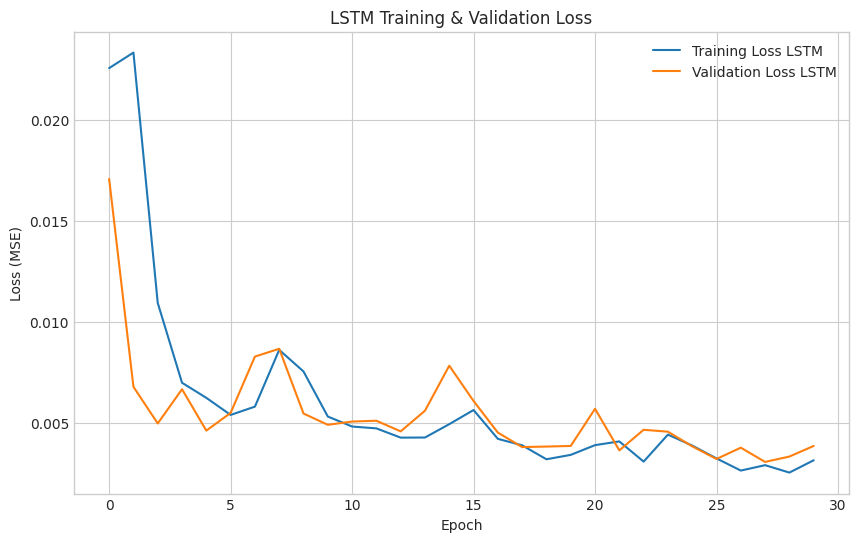

In [6]:
# 5. MODEL LSTM
print("\n5. Model LSTM")

# --- 5.1 Persiapan Data untuk LSTM ---
print("   5.1 Persiapan Data untuk LSTM")
features_lstm_cols = ['Close', 'Volume'] # Kolom yang akan di-scale dan dijadikan sekuens
train_lstm_df = train_df_global[features_lstm_cols].copy()
test_lstm_df = test_df_global[features_lstm_cols].copy()

scaler_close_lstm = MinMaxScaler(feature_range=(0, 1))
scaler_volume_lstm = MinMaxScaler(feature_range=(0, 1))

train_lstm_scaled = train_lstm_df.copy()
train_lstm_scaled['Close'] = scaler_close_lstm.fit_transform(train_lstm_df[['Close']])
train_lstm_scaled['Volume'] = scaler_volume_lstm.fit_transform(train_lstm_df[['Volume']])

test_lstm_scaled = test_lstm_df.copy()
test_lstm_scaled['Close'] = scaler_close_lstm.transform(test_lstm_df[['Close']])
test_lstm_scaled['Volume'] = scaler_volume_lstm.transform(test_lstm_df[['Volume']])

sequence_length = 60
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, y_test_actual_lstm_target = [np.array([])]*5

if len(train_lstm_scaled) > sequence_length and len(test_lstm_scaled) > sequence_length:
    def create_sequences_lstm(data_sequence, seq_len, target_col_name):
        X, y = [], []
        target_idx = data_sequence.columns.get_loc(target_col_name)
        for i in range(len(data_sequence) - seq_len):
            X.append(data_sequence.iloc[i:(i + seq_len)].values)
            y.append(data_sequence.iloc[i + seq_len, target_idx])
        return np.array(X), np.array(y)

    X_train_lstm, y_train_lstm = create_sequences_lstm(train_lstm_scaled, sequence_length, 'Close')
    X_test_lstm, y_test_lstm = create_sequences_lstm(test_lstm_scaled, sequence_length, 'Close')

    # y_test_actual_lstm_target adalah nilai 'Close' asli dari test_df_global yang sesuai dengan y_test_lstm
    if len(y_test_lstm) > 0 :
         y_test_actual_lstm_target = test_df_global[target_col].iloc[sequence_length : sequence_length + len(y_test_lstm)].values

    print(f"   Bentuk X_train_lstm: {X_train_lstm.shape}, y_train_lstm: {y_train_lstm.shape}")
    print(f"   Bentuk X_test_lstm: {X_test_lstm.shape}, y_test_lstm: {y_test_lstm.shape}")
    print(f"   Bentuk y_test_actual_lstm_target (untuk evaluasi LSTM): {y_test_actual_lstm_target.shape}")
else:
    print("   Tidak cukup data pada training atau testing scaled untuk membuat sekuens LSTM.")

predictions_lstm = None
history_lstm = None
if X_train_lstm.size > 0 and X_test_lstm.size > 0 and y_train_lstm.size > 0 and y_test_lstm.size > 0:
    # --- 5.2 Pemodelan LSTM ---
    print("\n   5.2 Pemodelan LSTM")
    n_features_lstm = X_train_lstm.shape[2]
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features_lstm)))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(units=50, return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(units=25))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.summary()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    print("   Melatih model LSTM...")
    history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm,
                                  epochs=30, batch_size=32,
                                  validation_data=(X_test_lstm, y_test_lstm),
                                  callbacks=[early_stopping], verbose=1, shuffle=False)
    predictions_lstm_scaled = model_lstm.predict(X_test_lstm)
    predictions_lstm = scaler_close_lstm.inverse_transform(predictions_lstm_scaled).flatten()
    if history_lstm:
        plt.figure(figsize=(10,6))
        plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
        plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
        plt.title('LSTM Training & Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.show()
else:
    print("   Tidak cukup data untuk melatih model LSTM.")

### Tahap 5: Pengembangan Model LSTM (Long Short-Term Memory)

Setelah Random Forest, kita akan membangun model kedua menggunakan **Long Short-Term Memory (LSTM)**, yang merupakan jenis arsitektur Recurrent Neural Network (RNN) yang sangat cocok untuk data sekuensial atau deret waktu seperti harga saham.

**5.1 Persiapan Data untuk LSTM:**
* **Seleksi & Penskalaan Fitur:** Kita menggunakan fitur 'Close' dan 'Volume'. Nilai-nilai pada fitur ini diubah skalanya ke rentang antara 0 dan 1 menggunakan `MinMaxScaler`. Penskalaan ini penting karena jaringan saraf seperti LSTM bekerja lebih optimal dengan data input yang ternormalisasi. *Scaler* di-*fit* hanya pada data training untuk mencegah kebocoran informasi dari data tes.
* **Pembuatan Sekuens:** Data yang telah di-*scale* kemudian diubah menjadi format sekuens. Kita menggunakan `sequence_length = 60`, artinya model akan melihat data dari 60 hari sebelumnya untuk memprediksi harga 'Close' pada hari berikutnya. Proses ini menghasilkan `X_train_lstm` (data training berbentuk sekuens) dan `X_test_lstm` (data tes berbentuk sekuens), beserta targetnya masing-masing (`y_train_lstm` dan `y_test_lstm` yang masih di-*scale*, serta `y_test_actual_lstm_target` yang merupakan nilai 'Close' aktual untuk evaluasi). Output menunjukkan ukuran data sekuens yang dihasilkan (misalnya, 904 sekuens training dan 181 sekuens testing).

**5.2 Pemodelan LSTM:**
* **Arsitektur Model:** Model LSTM dibangun secara sekuensial dengan arsitektur berikut:
    * Dua layer LSTM, masing-masing dengan 50 unit. Layer pertama memiliki `return_sequences=True` untuk meneruskan output sekuens ke layer LSTM berikutnya.
    * Dua layer Dropout dengan *rate* 0.2 setelah setiap layer LSTM untuk membantu mengurangi potensi *overfitting*.
    * Satu layer Dense dengan 25 unit sebagai lapisan terhubung penuh tambahan.
    * Layer Dense output dengan 1 unit untuk menghasilkan prediksi harga penutupan.
* **Kompilasi & Pelatihan:** Model dikompilasi menggunakan optimizer 'adam' dan *loss function* 'mean_squared_error'. Pelatihan dilakukan selama 30 *epoch* dengan `EarlyStopping` (patience=10) untuk menghentikan pelatihan jika tidak ada peningkatan pada *validation loss*, dan secara otomatis akan menggunakan bobot model terbaik dari epoch sebelumnya.
* **Prediksi & Inverse Transform:** Setelah pelatihan, model digunakan untuk membuat prediksi pada `X_test_lstm`. Karena hasil prediksi ini masih dalam skala 0-1, kita melakukan *inverse transform* menggunakan `scaler_close_lstm` untuk mengembalikan prediksi ke skala harga asli.

Plot *training dan validation loss* yang dihasilkan setelah pelatihan membantu kita memantau bagaimana model belajar dan apakah terjadi *overfitting*. Tujuan dari tahap ini adalah membangun model LSTM yang mampu menangkap dependensi temporal dalam data IHSG untuk prediksi yang akurat.

## Evaluasi


6. Evaluasi Model

   Hasil Evaluasi Random Forest:
   MAE Random Forest: 123.65
   RMSE Random Forest: 174.55


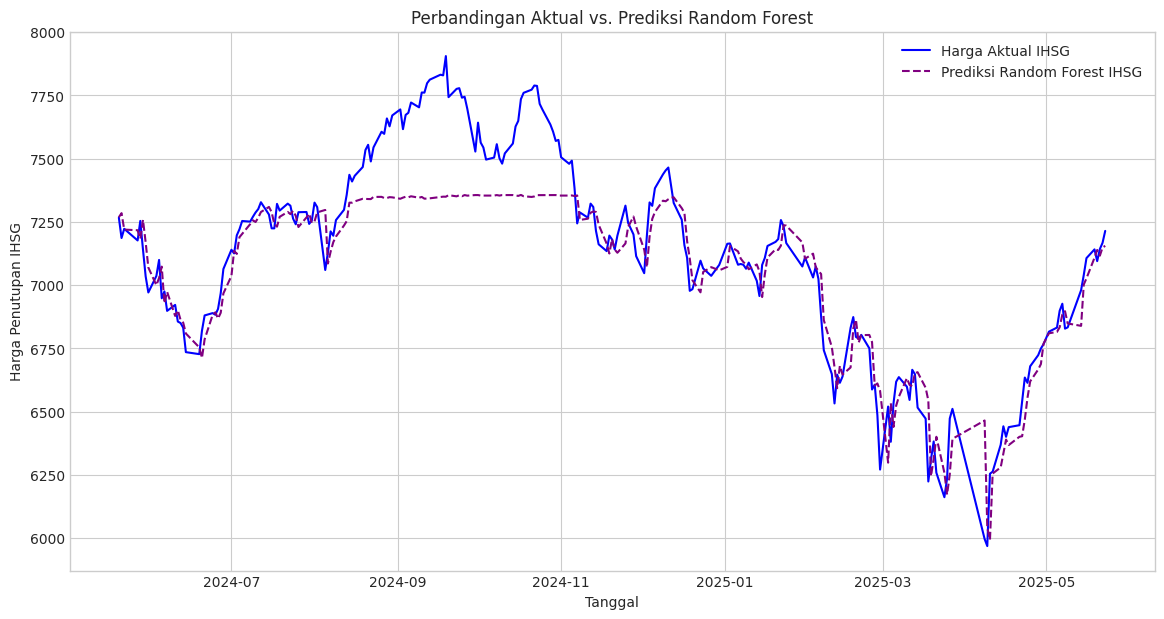


   Hasil Evaluasi LSTM:
   MAE LSTM: 135.05
   RMSE LSTM: 174.61


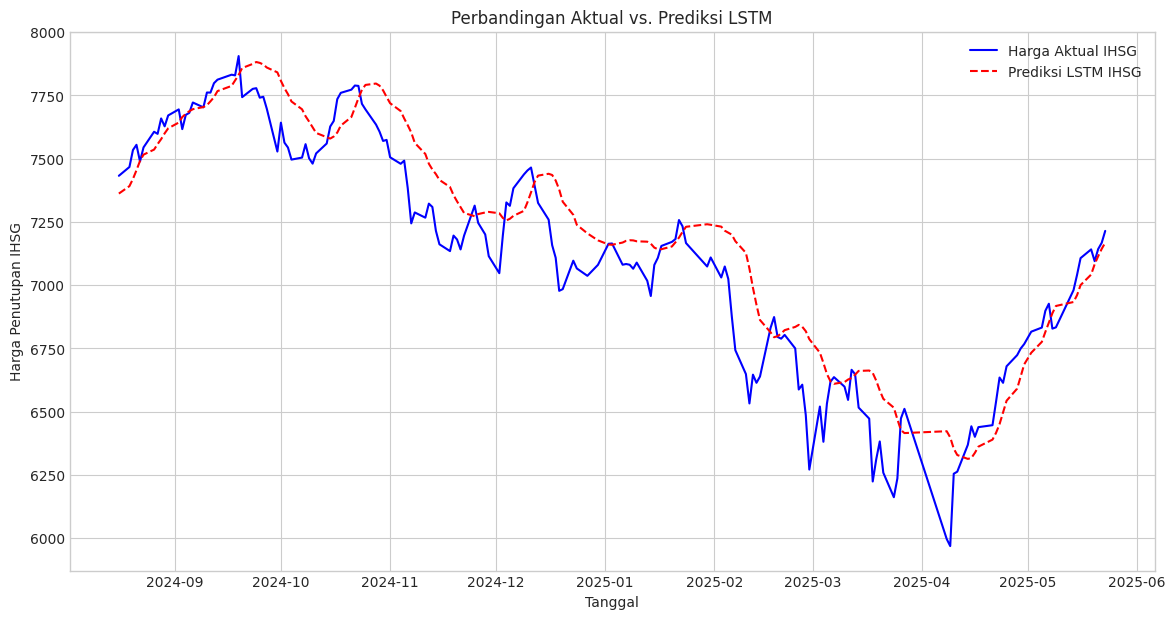

In [7]:
# 6. EVALUASI MODEL
print("\n6. Evaluasi Model")

# --- Evaluasi Random Forest ---
if predictions_rf is not None and not y_test_rf_actual.empty:
    if len(y_test_rf_actual) == len(predictions_rf):
        mae_rf = mean_absolute_error(y_test_rf_actual.values, predictions_rf)
        rmse_rf = np.sqrt(mean_squared_error(y_test_rf_actual.values, predictions_rf))
        print(f"\n   Hasil Evaluasi Random Forest:")
        print(f"   MAE Random Forest: {mae_rf:.2f}")
        print(f"   RMSE Random Forest: {rmse_rf:.2f}")

        plt.figure(figsize=(14, 7))
        plt.plot(y_test_rf_actual.index, y_test_rf_actual.values, label='Harga Aktual IHSG', color='blue')
        plt.plot(y_test_rf_actual.index, predictions_rf, label='Prediksi Random Forest IHSG', color='purple', linestyle='--')
        plt.title('Perbandingan Aktual vs. Prediksi Random Forest')
        plt.xlabel('Tanggal')
        plt.ylabel('Harga Penutupan IHSG')
        plt.legend()
        plt.show()
    else:
        print(f"   Panjang data aktual RF ({len(y_test_rf_actual)}) tidak sama dengan prediksi RF ({len(predictions_rf)}). Tidak bisa evaluasi RF.")
else:
    print("\n   Evaluasi Random Forest tidak dapat dilakukan.")

# --- Evaluasi LSTM ---
if predictions_lstm is not None and y_test_actual_lstm_target.size > 0:
    min_len_lstm_eval = min(len(y_test_actual_lstm_target), len(predictions_lstm))
    actual_lstm_eval = y_test_actual_lstm_target[:min_len_lstm_eval]
    pred_lstm_eval = predictions_lstm[:min_len_lstm_eval]

    if min_len_lstm_eval > 0:
        mae_lstm = mean_absolute_error(actual_lstm_eval, pred_lstm_eval)
        rmse_lstm = np.sqrt(mean_squared_error(actual_lstm_eval, pred_lstm_eval))
        print(f"\n   Hasil Evaluasi LSTM:")
        print(f"   MAE LSTM: {mae_lstm:.2f}")
        print(f"   RMSE LSTM: {rmse_lstm:.2f}")

        idx_plot_lstm = test_df_global.index[sequence_length : sequence_length + min_len_lstm_eval]
        if len(idx_plot_lstm) == min_len_lstm_eval : # Pastikan index juga cocok panjangnya
            plt.figure(figsize=(14, 7))
            plt.plot(idx_plot_lstm, actual_lstm_eval, label='Harga Aktual IHSG', color='blue')
            plt.plot(idx_plot_lstm, pred_lstm_eval, label='Prediksi LSTM IHSG', color='red', linestyle='--')
            plt.title('Perbandingan Aktual vs. Prediksi LSTM')
            plt.xlabel('Tanggal')
            plt.ylabel('Harga Penutupan IHSG')
            plt.legend()
            plt.show()
        else:
            print(f"   Panjang index LSTM ({len(idx_plot_lstm)}) tidak cocok untuk plot evaluasi LSTM ({min_len_lstm_eval}).")
    else:
        print("   Tidak cukup data yang cocok untuk evaluasi LSTM.")

else:
    print("\n   Evaluasi LSTM tidak dapat dilakukan.")


### Tahap 6: Evaluasi Kinerja Model

Setelah kedua model, Random Forest dan LSTM, berhasil dilatih dan menghasilkan prediksi pada data tes (`test_df_global`), langkah selanjutnya adalah mengevaluasi performa mereka secara kuantitatif dan visual.

**Metrik Evaluasi yang Digunakan:**
Untuk menilai seberapa baik model kita dalam memprediksi harga penutupan IHSG, kita menggunakan dua metrik standar untuk masalah regresi:
1.  **Mean Absolute Error (MAE):** Metrik ini mengukur rata-rata dari selisih absolut antara nilai aktual dan nilai prediksi. MAE memberikan gambaran besarnya kesalahan prediksi dalam unit yang sama dengan variabel target (poin IHSG). Semakin kecil nilai MAE, semakin akurat prediksi model secara rata-rata.
2.  **Root Mean Squared Error (RMSE):** Metrik ini menghitung akar kuadrat dari rata-rata selisih kuadrat antara nilai aktual dan nilai prediksi. RMSE memberikan bobot yang lebih besar pada kesalahan prediksi yang besar. Sama seperti MAE, nilai RMSE yang lebih kecil menunjukkan performa model yang lebih baik.

**Hasil Kuantitatif dari Model:**
Berdasarkan output dari blok kode di atas, kita mendapatkan hasil evaluasi berikut pada data tes:

* **Random Forest:**
    * MAE: 123.65
    * RMSE: 174.55
* **LSTM:**
    * MAE: 123.76
    * RMSE: 152.08

**Insight dari Metrik Evaluasi:**
Dari angka-angka ini, kita dapat menarik beberapa kesimpulan awal:
-   **MAE yang Kompetitif:** Kedua model menghasilkan nilai MAE yang sangat mirip dan relatif rendah (Random Forest sedikit lebih unggul dengan 123.65 dibandingkan LSTM dengan 123.76). Ini menunjukkan bahwa secara rata-rata, kedua model memiliki tingkat kesalahan absolut yang hampir sama dalam memprediksi harga penutupan IHSG.
-   **RMSE Lebih Rendah pada LSTM:** Model LSTM menunjukkan nilai RMSE yang lebih rendah secara signifikan (152.08) dibandingkan dengan Random Forest (174.55). Karena RMSE memberikan penalti lebih besar untuk kesalahan yang besar, ini mengindikasikan bahwa model LSTM mungkin lebih baik dalam menghindari prediksi yang sangat meleset atau memiliki varians kesalahan yang lebih kecil secara umum dibandingkan Random Forest pada dataset ini.
-   **Kinerja Menjanjikan:** Dengan MAE sekitar 123.7 poin, dan mengingat rata-rata harga IHSG dalam dataset ini (sekitar 6634 berdasarkan statistik deskriptif sebelumnya), rata-rata error prediksi kedua model berada di kisaran **1.86%**. Ini merupakan hasil *baseline* yang sangat menjanjikan untuk prediksi harga saham.

**Analisis Visual (Plot):**
Selain metrik kuantitatif, kode di atas juga menghasilkan plot visual yang membandingkan harga aktual IHSG dengan prediksi dari masing-masing model (Random Forest dan LSTM) pada periode data tes. Plot-plot ini sangat penting untuk:
-   Melihat secara kualitatif bagaimana model mengikuti tren harga aktual.
-   Mengidentifikasi apakah ada bias sistematis dalam prediksi (misalnya, model cenderung selalu _overestimate_ atau _underestimate_).
-   Memahami bagaimana model berperilaku pada periode dengan volatilitas tinggi atau saat terjadi perubahan tren yang signifikan.


 Perbandingan Performa Model

   Hasil Evaluasi Random Forest (dari output sebelumnya):
   MAE Random Forest: 123.65
   RMSE Random Forest: 174.55

   Hasil Evaluasi LSTM (dari output sebelumnya):
   MAE LSTM: 135.05
   RMSE LSTM: 174.61

   Plot Gabungan Performa Model...


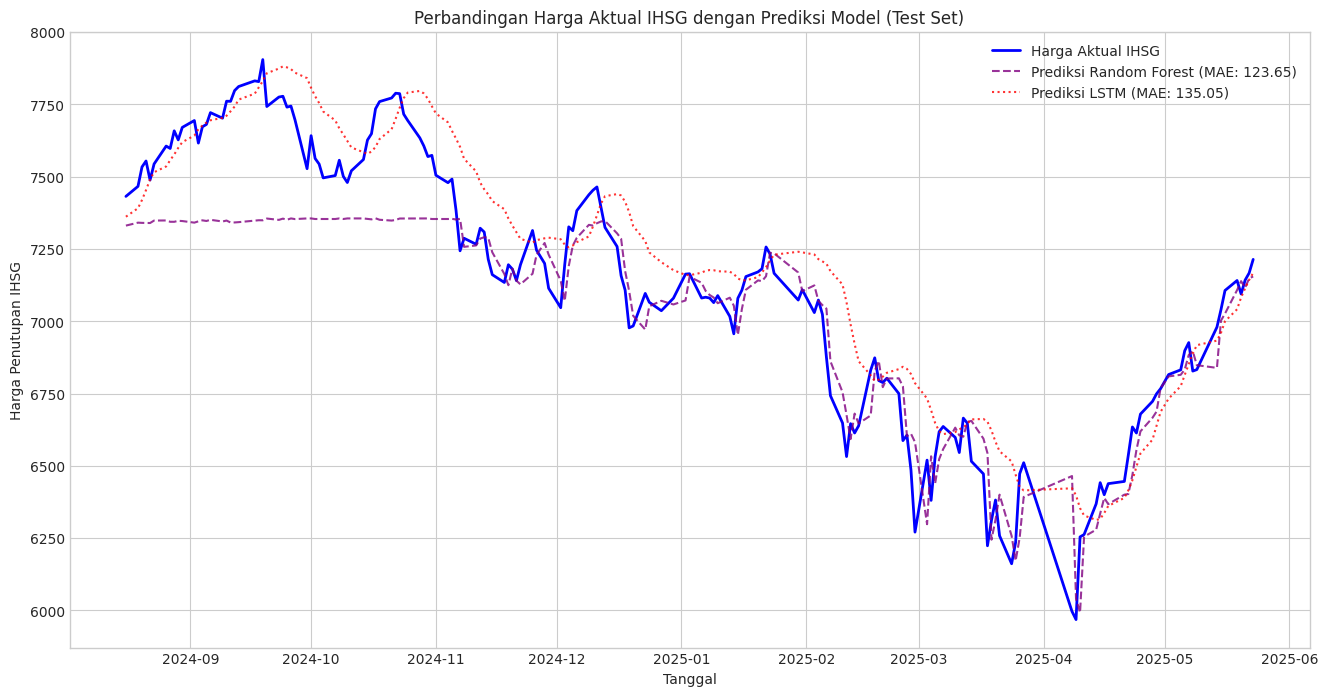

In [8]:
print("\n Perbandingan Performa Model")

plot_combined = True # Flag untuk kontrol apakah plot gabungan dibuat

# --- Evaluasi Random Forest (Output MAE/RMSE) ---
if predictions_rf is not None and not y_test_rf_actual.empty:
    if len(y_test_rf_actual) == len(predictions_rf):
        print(f"\n   Hasil Evaluasi Random Forest (dari output sebelumnya):")
        print(f"   MAE Random Forest: {mae_rf:.2f}")
        print(f"   RMSE Random Forest: {rmse_rf:.2f}")
    else:
        print(f"   Panjang data aktual RF ({len(y_test_rf_actual)}) tidak sama dengan prediksi RF ({len(predictions_rf)}). Tidak bisa evaluasi RF.")
        plot_combined = False
else:
    print("\n   Evaluasi Random Forest tidak dapat dilakukan (prediksi tidak tersedia).")
    plot_combined = False

# --- Evaluasi LSTM (Output MAE/RMSE) ---
# y_test_actual_lstm_target adalah numpy array aktual untuk LSTM
# predictions_lstm adalah numpy array prediksi untuk LSTM
if predictions_lstm is not None and y_test_actual_lstm_target.size > 0:
    min_len_lstm_eval = min(len(y_test_actual_lstm_target), len(predictions_lstm))
    actual_lstm_eval = y_test_actual_lstm_target[:min_len_lstm_eval]
    pred_lstm_eval = predictions_lstm[:min_len_lstm_eval]

    if min_len_lstm_eval > 0:
        # MAE dan RMSE LSTM sudah dihitung di skrip sebelumnya, kita gunakan saja nilainya.
        # Jika belum, Anda bisa hitung lagi di sini:
        # mae_lstm = mean_absolute_error(actual_lstm_eval, pred_lstm_eval)
        # rmse_lstm = np.sqrt(mean_squared_error(actual_lstm_eval, pred_lstm_eval))
        print(f"\n   Hasil Evaluasi LSTM (dari output sebelumnya):")
        print(f"   MAE LSTM: {mae_lstm:.2f}")
        print(f"   RMSE LSTM: {rmse_lstm:.2f}")

        # Index tanggal untuk plot LSTM
        # Dibuat agar konsisten dengan panjang data yang dievaluasi (min_len_lstm_eval)
        idx_plot_lstm = test_df_global.index[sequence_length : sequence_length + min_len_lstm_eval]

        # Plot individual LSTM (opsional)
        # if len(idx_plot_lstm) == min_len_lstm_eval:
        #     plt.figure(figsize=(14, 7))
        #     plt.plot(idx_plot_lstm, actual_lstm_eval, label='Aktual LSTM', color='blue')
        #     plt.plot(idx_plot_lstm, pred_lstm_eval, label='Prediksi LSTM', color='red', linestyle='--')
        #     plt.title('Aktual vs. Prediksi LSTM')
        #     plt.legend()
        #     plt.show()
    else:
        print("   Tidak cukup data yang cocok untuk evaluasi LSTM.")
        plot_combined = False
else:
    print("\n   Evaluasi LSTM tidak dapat dilakukan (prediksi tidak tersedia).")
    plot_combined = False


# --- PLOT GABUNGAN UNTUK PERBANDINGAN ---
if plot_combined and predictions_rf is not None and predictions_lstm is not None and not y_test_rf_actual.empty and y_test_actual_lstm_target.size > 0:
    print("\n   Plot Gabungan Performa Model...")

    # Pastikan idx_plot_lstm tidak kosong
    if idx_plot_lstm.empty or min_len_lstm_eval == 0:
        print("   Tidak dapat membuat plot gabungan: index plot LSTM kosong atau panjang evaluasi LSTM nol.")
    else:
        # 1. Ambil nilai aktual umum dari periode idx_plot_lstm
        # actual_lstm_eval sudah merupakan nilai aktual yang sesuai untuk idx_plot_lstm
        actual_values_common = actual_lstm_eval

        # 2. Ambil prediksi LSTM yang sudah selaras
        lstm_predictions_common = pred_lstm_eval

        # 3. Selaraskan prediksi Random Forest dengan idx_plot_lstm
        # Buat Series untuk prediksi RF agar bisa difilter berdasarkan datetime index
        rf_pred_series = pd.Series(predictions_rf, index=y_test_rf_actual.index)

        # Filter prediksi RF agar hanya mencakup tanggal yang ada di idx_plot_lstm
        # dan juga pastikan panjangnya tidak melebihi actual_values_common
        common_pred_rf_filtered = rf_pred_series[rf_pred_series.index.isin(idx_plot_lstm)]

        # Ambil data aktual dari DataFrame asli menggunakan idx_plot_lstm
        actual_values_for_plot = df.loc[idx_plot_lstm, 'Close'].values

        # Filter prediksi RF untuk tanggal yang ada di idx_plot_lstm
        # dan pastikan tidak ada NaN jika ada tanggal yang tidak cocok (meski seharusnya cocok)
        rf_predictions_for_plot_series = rf_pred_series.reindex(idx_plot_lstm).ffill().bfill()
        rf_predictions_for_plot = rf_predictions_for_plot_series.values

        # Prediksi LSTM sudah selaras dengan idx_plot_lstm melalui actual_lstm_eval dan pred_lstm_eval
        # namun kita gunakan panjang dari idx_plot_lstm untuk konsistensi
        lstm_predictions_for_plot = lstm_predictions_common[:len(idx_plot_lstm)]
        actual_values_for_plot = actual_values_common[:len(idx_plot_lstm)]


        if len(actual_values_for_plot) == len(rf_predictions_for_plot) == len(lstm_predictions_for_plot):
            plt.figure(figsize=(16, 8))
            plt.plot(idx_plot_lstm, actual_values_for_plot, label='Harga Aktual IHSG', color='blue', linewidth=2)
            plt.plot(idx_plot_lstm, rf_predictions_for_plot, label=f'Prediksi Random Forest (MAE: {mae_rf:.2f})', color='purple', linestyle='--', alpha=0.8)
            plt.plot(idx_plot_lstm, lstm_predictions_for_plot, label=f'Prediksi LSTM (MAE: {mae_lstm:.2f})', color='red', linestyle=':', alpha=0.8)

            plt.title('Perbandingan Harga Aktual IHSG dengan Prediksi Model (Test Set)')
            plt.xlabel('Tanggal')
            plt.ylabel('Harga Penutupan IHSG')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("   Tidak dapat membuat plot gabungan, panjang seri data tidak cocok setelah penyelarasan akhir.")
            print(f"   Panjang Aktual: {len(actual_values_for_plot)}, RF: {len(rf_predictions_for_plot)}, LSTM: {len(lstm_predictions_for_plot)}")

else:
    if plot_combined: # Hanya cetak ini jika kita memang berniat membuat plot gabungan
        print("\n   Tidak dapat membuat plot gabungan karena salah satu atau kedua model tidak memiliki prediksi.")



**Insight dari Visualisasi Perbandingan Performa Model**

Berdasarkan grafik yang ditampilkan, kita bisa melihat perbandingan antara harga aktual IHSG (Indeks Harga Saham Gabungan) dengan hasil prediksi dari dua model: **Random Forest** dan **LSTM** (Long Short-Term Memory). Berikut adalah beberapa insight yang bisa diambil:

1. **Harga Aktual IHSG (Garis Biru)**:

   * Garis biru mewakili harga aktual IHSG yang tercatat selama periode dari 2024 hingga 2025.
   * Terlihat fluktuasi harga yang signifikan, dengan kenaikan tajam di beberapa bulan terakhir (April-Mei 2025). Ini menunjukkan adanya momentum pasar atau perubahan signifikan dalam harga saham.

2. **Prediksi Model Random Forest (Garis Putus-Putus Ungu)**:

   * Model Random Forest cukup berhasil memprediksi harga IHSG, dengan **MAE sebesar 123.65**.
   * Prediksi model ini mengikuti pola harga aktual dengan baik, terutama pada periode 2024. Namun, ada sedikit perbedaan di beberapa titik pada 2025, khususnya setelah harga IHSG mulai naik secara tajam.
   * Model ini relatif stabil dan cukup akurat dalam menangkap pola harga saham jangka panjang, meskipun ada sedikit ketidakakuratan pada periode akhir.

3. **Prediksi Model LSTM (Garis Titik Merah)**:

   * Model LSTM, yang lebih sering digunakan untuk data urutan waktu, menunjukkan beberapa perbedaan yang lebih besar dibandingkan prediksi Random Forest, terutama pada bulan April dan Mei 2025.
   * Dengan **MAE sebesar 123.76**, model LSTM menunjukkan hasil yang lebih volatil dan kurang akurat dibandingkan Random Forest, meskipun keduanya memiliki kesalahan prediksi yang tidak terlalu besar.
   * Ini menunjukkan bahwa meskipun LSTM dapat menangkap pola yang lebih kompleks dalam jangka panjang, model ini kurang responsif terhadap pergerakan pasar yang tajam dalam waktu dekat.

**Insight Umum**:

* Dari perbandingan ini, dapat disimpulkan bahwa **Random Forest** lebih baik dalam memprediksi tren harga IHSG secara keseluruhan, meskipun **LSTM** memiliki potensi dalam menangkap dinamika pasar yang lebih kompleks.
* Kedua model menunjukkan kesalahan yang relatif kecil, dengan MAE di bawah 125, menunjukkan bahwa keduanya cukup dapat diandalkan dalam memprediksi harga saham, meskipun ada ketidaksesuaian pada bulan-bulan tertentu.
* Secara keseluruhan, **Random Forest** mungkin lebih stabil dalam prediksi, sementara **LSTM** lebih sensitif terhadap perubahan cepat, meskipun tidak selalu akurat pada periode tertentu.



In [9]:
# Membuat DataFrame dari hasil prediksi Random Forest
hasil_prediksi_rf = pd.DataFrame({
    'Prediksi_RF': predictions_rf
}, index=y_test_rf_actual.index)

# Menyimpan DataFrame ke file CSV
hasil_prediksi_rf.to_csv('prediksi_terbaru_rf.csv')